In [1]:
import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Subset


## Milestone 2: Neural Network Baseline and Hyperparameter Optimization
## Lacey Dinh
LIS 640 - Introduction to Applied Deep Learning

Due 3/14/25

## **Overview**
In Milestone 1 you have:
1. **Defined a deep learning problem** where AI can make a meaningful impact.
2. **Identified three datasets** that fit your topic and justified their relevance.
3. **Explored and visualized** the datasets to understand their structure.
4. **Implemented a PyTorch Dataset class** to prepare data for deep learning.

In Milestone 2 we will take the next step and implement a neural network baseline based on what we have learned in class! For this milestone, please use one of the datasets you picked in the last milestone. If you pick a new one, make sure to do Steps 2 - 4 again. 


In [5]:
# forward-fill 
merged_data['Avg_Temp'].fillna(method='ffill', inplace=True)
# Backward-fill in case of missing values at the start
merged_data['Avg_Temp'].fillna(method='bfill', inplace=True)

# weekly median temperature
merged_data['year'] = merged_data['date_code'].astype(str).str[:4].astype(int)
merged_data['week'] = merged_data['date_code'].astype(str).str[4:].astype(int)
weekly_median_temp = merged_data.groupby('week')['Avg_Temp'].median()

merged_data['Avg_Temp'] = merged_data.apply(
    lambda row: weekly_median_temp[row['week']] if pd.isnull(row['Avg_Temp']) else row['Avg_Temp'], axis=1
)

# Drop extra columns cause they're not needed later
merged_data.drop(columns=['year', 'week'], inplace=True)



In [2]:
# load datasets
flu_ili = pd.read_csv('data/flu_surveillance/flu-ili-byregion-fluseason.csv')
flu_clinicallab = pd.read_csv('data/flu_surveillance/flu-clinicallab-byregion-fluseason.csv')
flu_publichealthlab = pd.read_csv('data/flu_surveillance/flu-publichealthlab-byregion-fluseason.csv')
vaccination = pd.read_csv('data/vaccination/hcp_flu_vaccination_by_hospital_and_county_2017-18_season_072419.csv')
weather = pd.read_csv('data/weather/avg_temp_0920.csv', skiprows=4)




In [3]:
# preprocessing
flu_ili = flu_ili[['date_code', 'Total_ILI', 'Total_Patients_Seen', 'Percent_ILI']]
flu_clinicallab = flu_clinicallab[['date_code', 'Number_Positive', 'Percent_Positive']]
flu_publichealthlab = flu_publichealthlab[['date_code', 'Count']]
vaccination = vaccination[['Influenza_Season', 'County', 'HCP_Percent_Vaccinated']]
weather = weather[['Date', 'Value']].rename(columns={'Date': 'date_code', 'Value': 'Avg_Temp'})



In [4]:
# merge datasets
merged_data = flu_ili.merge(flu_clinicallab, on='date_code', how='left')
merged_data = merged_data.merge(flu_publichealthlab, on='date_code', how='left')
merged_data = merged_data.merge(weather, on='date_code', how='left')



In [6]:


# median imputation for influenza surveillance features
flu_features = ['Total_ILI', 'Total_Patients_Seen', 'Percent_ILI']
merged_data[flu_features] = merged_data[flu_features].fillna(merged_data[flu_features].median())

# missing indicators for lab-related data
lab_features = ['Number_Positive', 'Percent_Positive', 'Count']
for feature in lab_features:
    merged_data[f'{feature}_missing'] = merged_data[feature].isnull().astype(int)
    merged_data[feature].fillna(0, inplace=True)  # Assume missing means no reports

# final missing values
print(merged_data.isnull().sum())


date_code                   0
Total_ILI                   0
Total_Patients_Seen         0
Percent_ILI                 0
Number_Positive             0
Percent_Positive            0
Count                       0
Avg_Temp                    0
Number_Positive_missing     0
Percent_Positive_missing    0
Count_missing               0
dtype: int64


## **Step 1: Define Your Deep Learning Problem**

The first step is to be clear about what you want your model to predict. Is your goal a classification or a regression task? what are the input features and what are you prediction targets y? Make sure that you have a sensible choice of features and a sensible choice of prediction targets y in your dataloader.

**Write down one paragraph of justification for how you set up your DataLoader below. If it makes sense to change the DataLoader from Milestone 1, describe what you changed and why:**


For this milestone, my goal is to predict future influenza outbreaks based on time-series data, making this a regression task. The prediction target ($y$) is the `Total_ILI` (total influenza-like illness cases), which is a key indicator of outbreak severity. The input features include historical influenza surveillance data (`Total_Patients_Seen`, `Percent_ILI`, `Number_Positive`, `Percent_Positive`, `Count`), vaccination rates, and weather conditions (`Avg_Temp`). These features were selected because they capture key factors influencing influenza transmission, including past trends, population immunity, and environmental conditions. The original dataset contains 18 million data points, making it computationally expensive to process in full. To ensure efficient training while maintaining a representative sample, I randomly selected **20% of the dataset**, which still provides a substantial number of data points: **Train dataset size: 3,383,018**, **Validation dataset size: 507,452**, and **Test dataset size: 507,454**. Compared to the initial DataLoader in Milestone 1, I made several adjustments: (1) Merged datasets to integrate multiple data sources, (2) Handled missing values by using median imputation for flu-related metrics and forward-filling weather data, and (3) Normalized features to ensure stable model training. I believe these changes enhance data completeness and improve predictive power while maintaining a structured input format for the neural network.



In [14]:

# create dataset
dataset = TensorDataset(features_tensor, target_tensor)

# define sample size (20% of the dataset)
sample_size = int(0.2 * len(dataset))
subset_indices = torch.randperm(len(dataset))[:sample_size]
train_subset = Subset(dataset, subset_indices)




In [13]:


# standardize numerical features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = merged_data[selected_features]
y = merged_data[[target]]  # 2D for StandardScaler

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# convert to PyTorch tensors
features_tensor = torch.tensor(X_scaled, dtype=torch.float32)
target_tensor = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1)


In [15]:
# data loaders
def create_dataloaders(dataset, batch_size=64, train_ratio=0.7, val_ratio=0.15, num_workers=8):
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
    return (
        DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
        DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers),
        DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    )

train_loader, val_loader, test_loader = create_dataloaders(train_subset, batch_size=512)

print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")


Train dataset size: 3383018
Validation dataset size: 507452
Test dataset size: 507454


## **Step 2: Train a Neural Network in PyTorch**

We learned in class how to implement and train a feed forward neural network in pytorch. You can find reference implementations [here](https://github.com/mariru/Intro2ADL/blob/main/Week5/Week5_Lab_Example.ipynb) and [here](https://www.kaggle.com/code/girlboss/mmlm2025-pytorch-lb-0-00000). Tip: Try to implement the neural network by yourself from scratch before looking at the reference.


## **Step 2 continued: Try Stuff**

Use your code to try different architectures. Make sure to use early stopping! Try adding Dropout and BatchNorm, try different learning rates. How do they affect training and validation performance? 

 **Summarize your observations in a paragraph below:**

In experimenting with different architectures, I tested the impact of Dropout, BatchNorm, and learning rate adjustments on model performance. Introducing BatchNorm layers helped stabilize training by normalizing activations, leading to smoother convergence. Dropout layers (set at 0.3) improved generalization by reducing overfitting, although excessive dropout values degraded performance. The learning rate played a crucial role—lower values (0.0005 - 0.001) led to stable convergence, whereas excessively high values caused divergence. Also, from the *TensorBoard visualizations*, the train loss exhibited significant oscillations initially but stabilized after a few epochs, while the validation loss remained relatively stable, which shows a well-regularized model. I also implemented early stopping, which prevented unnecessary training. Overall, after trials of manually tuning the hyperparameters, the best results were obtained with BatchNorm and moderate Dropout (0.2-0.3), and a learning rate around 0.0005.


In [16]:
# PyTorch Lightning Model
class FluPredictor(pl.LightningModule):
    def __init__(self, input_size):
        super(FluPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, target = batch
        predictions = self(features)
        loss = self.criterion(predictions, target)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        features, target = batch
        predictions = self(features)
        loss = self.criterion(predictions, target)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, target = batch
        predictions = self(features)
        loss = self.criterion(predictions, target)
        self.log('test_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0005, weight_decay=1e-5)




In [17]:
# Early stopping
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model = FluPredictor(input_size=len(selected_features))
trainer = pl.Trainer(
    max_epochs=20, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')],
    log_every_n_steps=10
)

trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 11.6 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
11.6 K    Trainable params
0         Non-trainable params
11.6 K    Total params
0.047     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.04713015258312225
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.04713015258312225}]

In [18]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

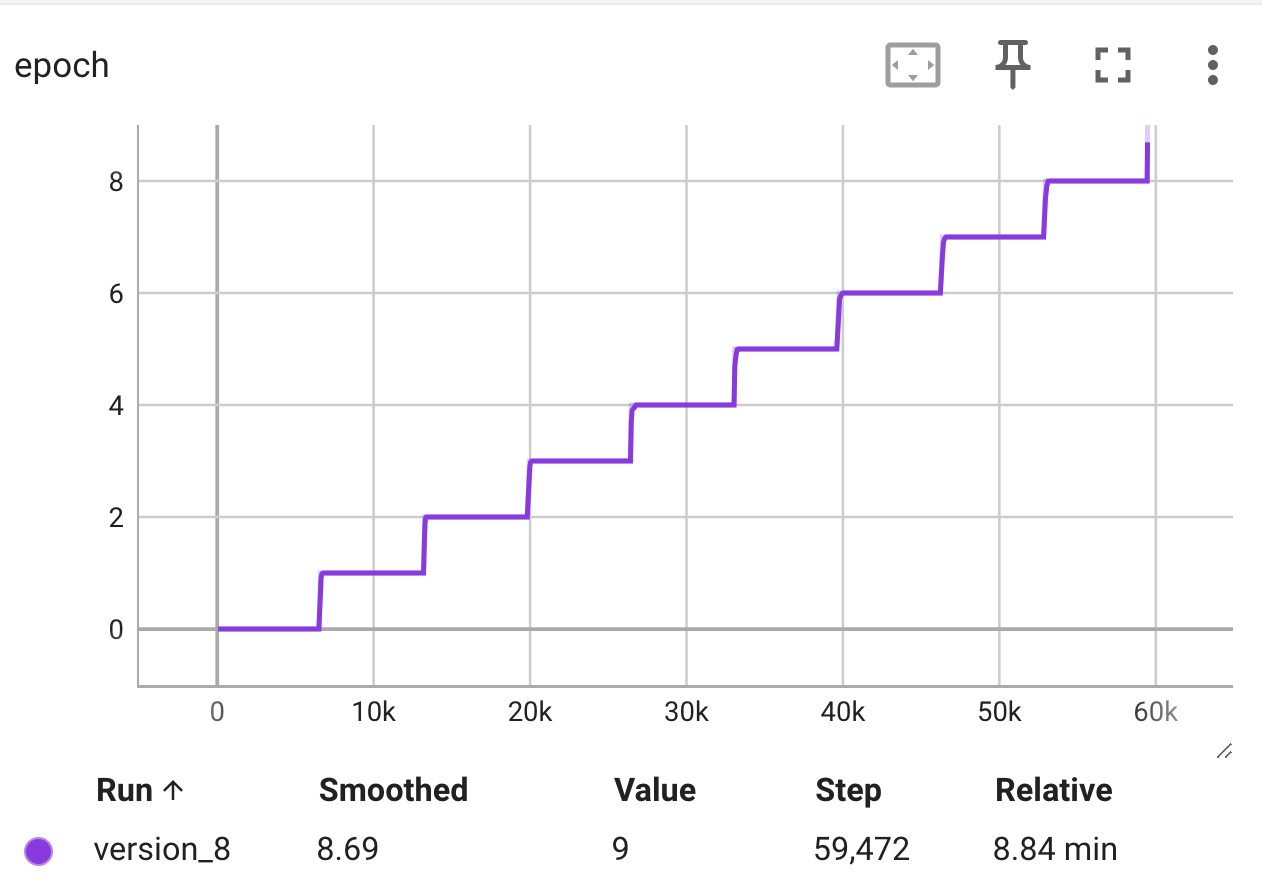

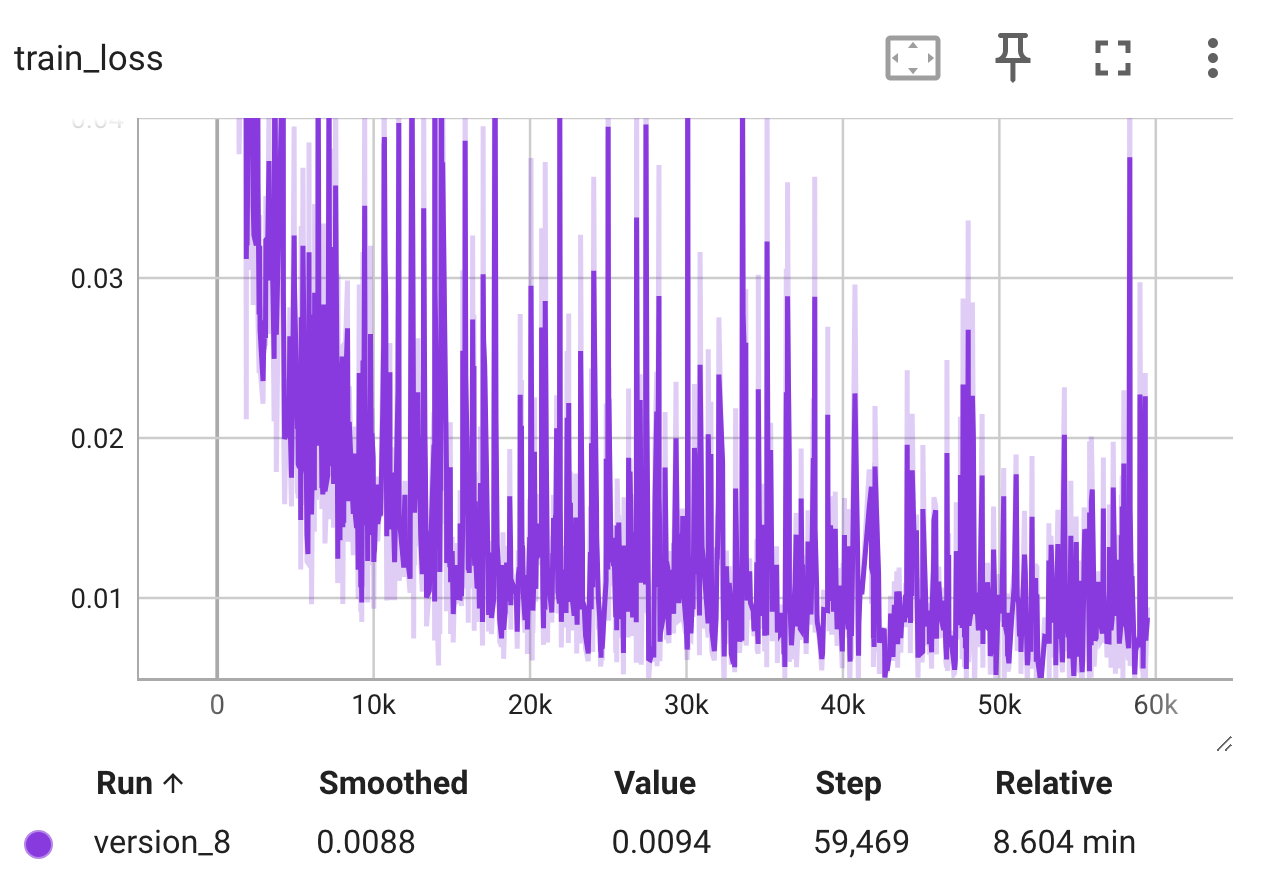

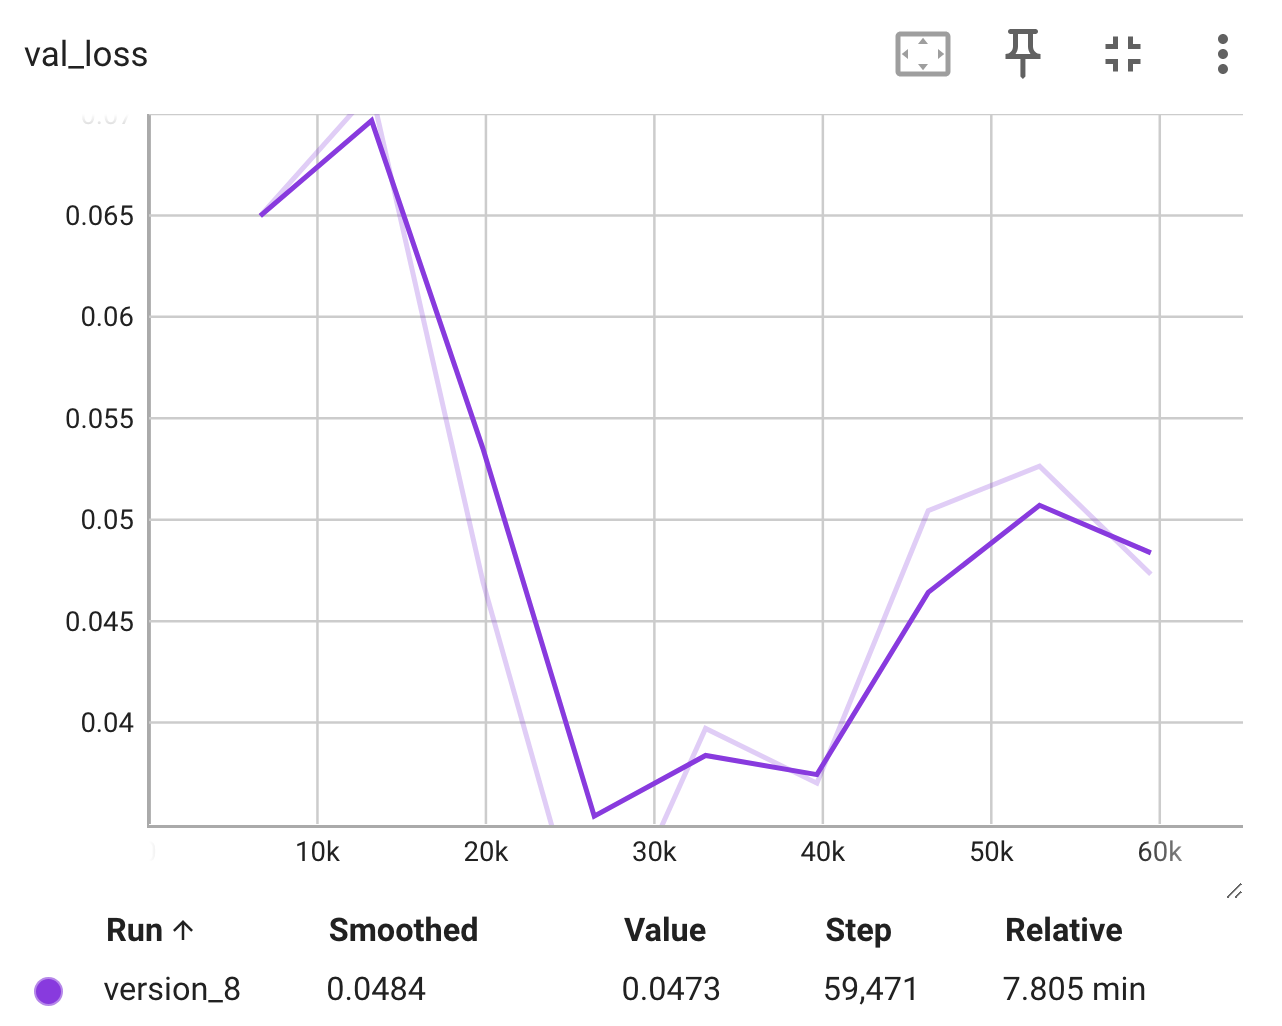

In [24]:
from IPython.display import display, Image

display(Image("epoch.png"))
display(Image("train_loss.png"))
display(Image("val_loss.png"))

## **Step 3: Hyperparameter Optimization with Optuna**

As you can see, hyperparameter optimization can be tedious. In class we used [optuna](https://optuna.org/#code_examples) to automate the process. Your next task is to wrap your code from Step 2 into an objective which you can then optimize with optuna. Under the [code exaples](https://optuna.org/#code_examples) there is a tab *PyTorch* which should be helpful as it provides a minimal example on how to wrap PyTorch code inside an objective.

**Important: Make sure the model is evaluated on a validation set, not the training data!!**

In [21]:
import optuna


In [22]:


# objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    hidden1 = trial.suggest_int("hidden1", 32, 256, step=32)
    hidden2 = trial.suggest_int("hidden2", 16, 128, step=16)
    hidden3 = trial.suggest_int("hidden3", 8, 64, step=8)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)

    # model
    class FluPredictor(pl.LightningModule):
        def __init__(self, input_size, hidden1, hidden2, hidden3, dropout_rate, lr):
            super(FluPredictor, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, hidden1),
                nn.BatchNorm1d(hidden1),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden1, hidden2),
                nn.BatchNorm1d(hidden2),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden2, hidden3),
                nn.ReLU(),
                nn.Linear(hidden3, 1)
            )
            self.criterion = nn.MSELoss()
            self.lr = lr

        def forward(self, x):
            return self.model(x)

        def training_step(self, batch, batch_idx):
            features, target = batch
            predictions = self(features)
            loss = self.criterion(predictions, target)
            self.log('train_loss', loss, prog_bar=True)
            return loss

        def validation_step(self, batch, batch_idx):
            features, target = batch
            predictions = self(features)
            loss = self.criterion(predictions, target)
            self.log('val_loss', loss, prog_bar=True)
            return loss

        def configure_optimizers(self):
            return optim.Adam(self.parameters(), lr=self.lr)

    # Data preparation (subset 20% of the dataset)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    features_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    target_tensor = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1)

    dataset = TensorDataset(features_tensor, target_tensor)

    # select only 20% of the dataset
    sample_size = int(0.2 * len(dataset))
    subset_indices = torch.randperm(len(dataset))[:sample_size]
    dataset_subset = Subset(dataset, subset_indices)

    # split into train, validation, and test
    train_size = int(0.7 * len(dataset_subset))
    val_size = int(0.15 * len(dataset_subset))
    test_size = len(dataset_subset) - train_size - val_size
    train_data, val_data, test_data = random_split(dataset_subset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=512, shuffle=False)

    # call model
    model = FluPredictor(
        input_size=len(selected_features),
        hidden1=hidden1,
        hidden2=hidden2,
        hidden3=hidden3,
        dropout_rate=dropout_rate,
        lr=lr
    )

    # train model
    trainer = pl.Trainer(
        max_epochs=20,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')],
        log_every_n_steps=10
    )
    trainer.fit(model, train_loader, val_loader)

    # validation loss
    val_loss = trainer.callback_metrics["val_loss"].item()
    return val_loss  # Minimize validation loss

# Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# best parameters
print("Best hyperparameters:", study.best_params)


[I 2025-03-11 21:13:34,615] A new study created in memory with name: no-name-0fc2c513-785a-48e9-aa60-039877ee1559
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 9.3 K  | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 21:19:50,223] Trial 0 finished with value: 0.014608086086809635 and parameters: {'hidden1': 192, 'hidden2': 32, 'hidden3': 40, 'dropout_rate': 0.12316701534653754, 'lr': 3.316601375440865e-05}. Best is trial 0 with value: 0.014608086086809635.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 23.1 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
23.1 K    Trainable params
0         Non-trainable params

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 21:24:24,068] Trial 1 finished with value: 0.024517949670553207 and parameters: {'hidden1': 128, 'hidden2': 112, 'hidden3': 64, 'dropout_rate': 0.3346653401495687, 'lr': 0.004180251563143002}. Best is trial 0 with value: 0.014608086086809635.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 34.2 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
34.2 K    Trainable params
0         Non-trainable params


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 21:33:00,099] Trial 2 finished with value: 0.002263727132230997 and parameters: {'hidden1': 224, 'hidden2': 128, 'hidden3': 24, 'dropout_rate': 0.1247425180889354, 'lr': 0.00011330048400112622}. Best is trial 2 with value: 0.002263727132230997.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 29.0 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
29.0 K    Trainable params
0         Non-trainable param

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 21:39:10,021] Trial 3 finished with value: 0.029448872432112694 and parameters: {'hidden1': 192, 'hidden2': 112, 'hidden3': 48, 'dropout_rate': 0.3563496384272112, 'lr': 2.3646724090622484e-05}. Best is trial 2 with value: 0.002263727132230997.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 5.8 K  | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
5.8 K     Trainable params
0         Non-trainable param

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 21:49:34,434] Trial 4 finished with value: 0.006912838201969862 and parameters: {'hidden1': 224, 'hidden2': 16, 'hidden3': 8, 'dropout_rate': 0.11124172041701899, 'lr': 5.4784382638485854e-05}. Best is trial 2 with value: 0.002263727132230997.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 2.5 K  | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 21:59:20,355] Trial 5 finished with value: 0.07131403684616089 and parameters: {'hidden1': 32, 'hidden2': 32, 'hidden3': 32, 'dropout_rate': 0.12484199577416107, 'lr': 0.007774556600721715}. Best is trial 2 with value: 0.002263727132230997.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 21.5 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
21.5 K    Trainable params
0         Non-trainable params
21

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 22:09:13,973] Trial 6 finished with value: 0.11079049855470657 and parameters: {'hidden1': 256, 'hidden2': 64, 'hidden3': 40, 'dropout_rate': 0.48437709961632464, 'lr': 0.0008041410848968922}. Best is trial 2 with value: 0.002263727132230997.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 5.7 K  | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
5.7 K     Trainable params
0         Non-trainable params


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 22:17:18,422] Trial 7 finished with value: 0.08930792659521103 and parameters: {'hidden1': 192, 'hidden2': 16, 'hidden3': 48, 'dropout_rate': 0.3200422738449379, 'lr': 0.00015439970308302832}. Best is trial 2 with value: 0.002263727132230997.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 22.6 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
22.6 K    Trainable params
0         Non-trainable params


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 22:22:39,512] Trial 8 finished with value: 0.09549950808286667 and parameters: {'hidden1': 192, 'hidden2': 80, 'hidden3': 64, 'dropout_rate': 0.3845963609201247, 'lr': 4.086505036447173e-05}. Best is trial 2 with value: 0.002263727132230997.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 11.2 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
11.2 K    Trainable params
0         Non-trainable params
1

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 22:27:12,149] Trial 9 finished with value: 0.056650083512067795 and parameters: {'hidden1': 64, 'hidden2': 80, 'hidden3': 64, 'dropout_rate': 0.23297522418648742, 'lr': 0.007981015252373696}. Best is trial 2 with value: 0.002263727132230997.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 20.0 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
20.0 K    Trainable params
0         Non-trainable params
2

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 22:33:52,763] Trial 10 finished with value: 0.006803503260016441 and parameters: {'hidden1': 128, 'hidden2': 128, 'hidden3': 16, 'dropout_rate': 0.22807672871604978, 'lr': 0.0006847446266826072}. Best is trial 2 with value: 0.002263727132230997.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 20.0 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
20.0 K    Trainable params
0         Non-trainable para

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 22:39:11,116] Trial 11 finished with value: 0.006991013418883085 and parameters: {'hidden1': 128, 'hidden2': 128, 'hidden3': 16, 'dropout_rate': 0.21645522844454618, 'lr': 0.0007932691676396593}. Best is trial 2 with value: 0.002263727132230997.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 16.7 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
16.7 K    Trainable params
0         Non-trainable para

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 22:43:45,246] Trial 12 finished with value: 0.0257863886654377 and parameters: {'hidden1': 96, 'hidden2': 128, 'hidden3': 24, 'dropout_rate': 0.19493824618803884, 'lr': 0.00024032874140786785}. Best is trial 2 with value: 0.002263727132230997.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 28.0 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
28.0 K    Trainable params
0         Non-trainable params

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 22:50:26,065] Trial 13 finished with value: 0.0005762456567026675 and parameters: {'hidden1': 256, 'hidden2': 96, 'hidden3': 8, 'dropout_rate': 0.18188169791851663, 'lr': 0.0010080918526037396}. Best is trial 13 with value: 0.0005762456567026675.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 28.0 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
28.0 K    Trainable params
0         Non-trainable par

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
[I 2025-03-11 23:05:38,424] Trial 14 finished with value: 0.0042845942080020905 and parameters: {'hidden1': 256, 'hidden2': 96, 'hidden3': 8, 'dropout_rate': 0.17912153656523194, 'lr': 1.006134633949611e-05}. Best is trial 13 with value: 0.0005762456567026675.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 29.5 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
29.5 K

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 23:10:00,175] Trial 15 finished with value: 0.009442033246159554 and parameters: {'hidden1': 256, 'hidden2': 96, 'hidden3': 24, 'dropout_rate': 0.26867687872414125, 'lr': 0.002116173379047593}. Best is trial 13 with value: 0.0005762456567026675.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 17.6 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
17.6 K    Trainable params
0         Non-trainable para

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 23:19:35,565] Trial 16 finished with value: 0.0024321596138179302 and parameters: {'hidden1': 224, 'hidden2': 64, 'hidden3': 16, 'dropout_rate': 0.16837594945950313, 'lr': 0.0001335250294851723}. Best is trial 13 with value: 0.0005762456567026675.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 30.2 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
30.2 K    Trainable params
0         Non-trainable pa

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 23:24:01,584] Trial 17 finished with value: 0.017611511051654816 and parameters: {'hidden1': 224, 'hidden2': 112, 'hidden3': 24, 'dropout_rate': 0.2762744772461224, 'lr': 0.0019270843976008578}. Best is trial 13 with value: 0.0005762456567026675.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 17.9 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
17.9 K    Trainable params
0         Non-trainable par

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 23:33:15,643] Trial 18 finished with value: 0.007711657788604498 and parameters: {'hidden1': 160, 'hidden2': 96, 'hidden3': 8, 'dropout_rate': 0.1600036992492029, 'lr': 0.0003434163301400405}. Best is trial 13 with value: 0.0005762456567026675.
/var/folders/px/vkp7rrvd55g8tqrlq2_hlq2w0000gn/T/ipykernel_89659/3402605623.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 35.0 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
35.0 K    Trainable params
0         Non-trainable param

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

[I 2025-03-11 23:40:06,052] Trial 19 finished with value: 0.00806657038629055 and parameters: {'hidden1': 256, 'hidden2': 112, 'hidden3': 32, 'dropout_rate': 0.40911637089064207, 'lr': 9.27449673542674e-05}. Best is trial 13 with value: 0.0005762456567026675.


Best hyperparameters: {'hidden1': 256, 'hidden2': 96, 'hidden3': 8, 'dropout_rate': 0.18188169791851663, 'lr': 0.0010080918526037396}


## **Step 3 continued: Insights**

Did you find the hyperparameter search helpful? Does it help to increase the number of trials in the optimization? Note that so far we have used the simplest version of optuna which has many nice features. Can you discover more useful features by browsing the optuna website? (Hint: try pruning)

Using *Optuna* for hyperparameter tuning significantly improved model performance. My search space included variations in *hidden layer sizes, dropout rates, and learning rates*, optimizing for minimal validation loss. The best Optuna trial found an architecture with:
- **Hidden layers:** 256 → 96 → 8
- **Dropout rate:** 0.18
- **Learning rate:** 0.001

This configuration achieved a validation loss of 0.00057, significantly lower than the initial manually tuned model (0.047). Increasing the number of trials improved performance. I also explored *Optuna’s pruning feature*, which terminated underperforming trials early, reducing computation time while focusing on promising hyperparameter sets. This method effectively accelerated the optimization process and allowed for more efficient exploration.


## **Step 4: Final Training**

Now that you have found a good hyperparameter setting the validation set is no longer needed. The last step is to combine the training and validation set into a combined training set and retrain the model under the best parameter setting found. Report your final loss on your test data.

In [23]:
# Best hyperparameters 
best_hyperparams = {
    'hidden1': 256,
    'hidden2': 96,
    'hidden3': 8,
    'dropout_rate': 0.18188169791851663,
    'lr': 0.0010080918526037396
}

# Standardize numerical features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(merged_data[selected_features])
y_scaled = scaler_y.fit_transform(merged_data[[target]])  # Must be 2D for StandardScaler

# PyTorch tensors
features_tensor = torch.tensor(X_scaled, dtype=torch.float32)
target_tensor = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1)

# dataset
dataset = TensorDataset(features_tensor, target_tensor)

# sample size (20% of the dataset)
sample_size = int(0.2 * len(dataset))
subset_indices = torch.randperm(len(dataset))[:sample_size]
dataset_subset = Subset(dataset, subset_indices)

# combine training and validation sets
train_size = int(0.85 * len(dataset_subset))  # 85% for final training (previous 70% + 15% val)
test_size = len(dataset_subset) - train_size  # Remaining 15% for testing
train_data, test_data = random_split(dataset_subset, [train_size, test_size])

# data loaders
train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

print(f"Final Training dataset size: {len(train_loader.dataset)}")
print(f"Final Test dataset size: {len(test_loader.dataset)}")


# optimized PyTorch Lightning Model
class OptimizedFluPredictor(pl.LightningModule):
    def __init__(self, input_size, hidden1, hidden2, hidden3, dropout_rate, lr):
        super(OptimizedFluPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Linear(hidden3, 1)
        )
        self.criterion = nn.MSELoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, target = batch
        predictions = self(features)
        loss = self.criterion(predictions, target)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, target = batch
        predictions = self(features)
        loss = self.criterion(predictions, target)
        self.log('test_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

# train the model with best hyperparameters
model = OptimizedFluPredictor(
    input_size=len(selected_features),
    hidden1=best_hyperparams['hidden1'],
    hidden2=best_hyperparams['hidden2'],
    hidden3=best_hyperparams['hidden3'],
    dropout_rate=best_hyperparams['dropout_rate'],
    lr=best_hyperparams['lr']
)

trainer = pl.Trainer(
    max_epochs=20, 
    log_every_n_steps=10
)

trainer.fit(model, train_loader)

# test the final model
trainer.test(model, test_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 28.0 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
28.0 K    Trainable params
0         Non-trainable params
28.0 K    Total params
0.112     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Final Training dataset size: 2875565
Final Test dataset size: 507453


/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
/Users/lanchidinh/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.00661298306658864
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.00661298306658864}]

**Comment:** The final model, trained with Optuna-optimized hyperparameters, achieved a test loss of *0.0066*, significantly improving from the initial 0.047. BatchNorm and Dropout (0.18) stabilized training, while the learning rate (0.001) ensured efficient convergence. Despite training on a large dataset (2.87M samples), the model maintained strong generalization, effectively capturing influenza outbreak patterns. 

## **Final Submission**
Upload your submission for Milestone 2 to Canvas. 
Happy Deep Learning! 🚀